# A simpl(er) Introduction to Hierarchical Models 
### Naive Bayesians, 2021


### Agenda

1. Univariate Model (Radon Gas)
    * Pooled 
    * Unpooled 
    * Hierarchical 

2. Multivariate model (Synthetic Data)
    * Pooled 
    * Unpooled 
    * Hierarchical 

#### Notebook Setup

In [1]:
%load_ext nb_black
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

<IPython.core.display.Javascript object>

In [2]:
import os
from scipy import stats
import pandas as pd
import numpy as np
from typing import Dict

# ML libraries
import pymc3 as pm
from sklearn.linear_model import LinearRegression

# Plotting and viz
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 15

<IPython.core.display.Javascript object>

## Univariate Regression - Radon Gas Example

Suppose the radon concentration for a specific house, $i$, in county, $c$ is related to if the house has a basement with the relationship:  

$$
\begin{align*}
\text{Pooled:  } \text{log_radon}_{i, c} = {} & \alpha + \beta \hspace{1mm} \text{floor}_{i, c} + \epsilon_{i, c}, \\
\text{Unpooled:  }  \text{log_radon}_{i, c} = {} & \alpha_{c} + \beta_{c} \hspace{1mm} \text{floor}_{i, c} + \epsilon_{i, c}
\end{align*}
$$

where $\alpha_{c}$ is the average radon concentration, $\text{floor}_{i, c}  = 0$ if the house has a basement  $\text{floor}_{i, c}  = 1$ if the house doesn't have a basement. 

In [ ]:
# Load data
def load_radon_data() -> pd.DataFrame:
    data = pd.read_csv(pm.get_data("radon.csv"))
    data = data[["county", "floor", "log_radon"]]
    return data


radon_data = load_radon_data()

counties = radon_data["county"].drop_duplicates().to_list()

print(f"Num counties: {len(counties)}")

# Map each county with an index
county_index_mapping = {county: index for index, county in enumerate(counties)}

radon_data = radon_data.assign(
    **{"county_index": lambda x: x["county"].map(county_index_mapping)}
)
display(radon_data)

### 1. Pooled Model Radon Gas Example

In [ ]:
# Build individual models
with pm.Model() as ind_radon_model:
    # Prior
    # ---> Regression Coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=1)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=1)
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = alpha + beta * radon_data["floor"]
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

In [ ]:
pm.plot_posterior(trace)
plt.show()

In [ ]:
with ind_radon_model:
    display(pm.summary(trace))

### 2. Unpooled Model Radon Gas Example

In [ ]:
# Build individual models
with pm.Model() as unpooled_radon_model:
    # Prior
    # ---> Regression Coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=len(counties))
    beta = pm.Normal("beta", mu=0, sigma=10, shape=len(counties))
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = (
        alpha[radon_data["county_index"]]
        + beta[radon_data["county_index"]] * radon_data["floor"]
    )
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

In [ ]:
with unpooled_radon_model:
    display(pm.summary(trace))

### 3. Hierarchical Model Radon Gas Example

In [ ]:
# Build individual models
with pm.Model() as hierarchical_radon_model:
    # Prior
    # -> Global prior
    mu_alpha_glob = pm.Normal("mu_alpha", mu=0, sigma=10)
    sigma_alpha_glob = pm.HalfCauchy("sig_alpha", 5)

    mu_beta_glob = pm.Normal("mu_beta", mu=0, sigma=10)
    sigma_beta_glob = pm.HalfCauchy("sig_beta", 5)

    # ---> Regression Coefficients
    alpha = pm.Normal(
        "alpha", mu=mu_alpha_glob, sigma=sigma_alpha_glob, shape=len(counties)
    )
    beta = pm.Normal(
        "beta", mu=mu_beta_glob, sigma=sigma_beta_glob, shape=len(counties)
    )
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = (
        alpha[radon_data["county_index"]]
        + beta[radon_data["county_index"]] * radon_data["floor"]
    )
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

In [ ]:
with hierarchical_radon_model:
    display(pm.summary(trace))

## Multivariate Model - Synthetic Example

### Data Model

Suppose you have data from 2 different sites. 
\begin{align*}
y_{a, i} =  \pmb{w}_{a}^\textsf{T}\pmb{x}_{a, i} + \epsilon_{i}  \;\;\;\;
y_{b, i} = \pmb{w}_{b}^\textsf{T}\pmb{x}_{b, i} + \epsilon_{i} \\
\end{align*}



The data can be collected into a observation vector as follows:
\begin{align*}
\pmb{y} = {} & \begin{bmatrix} \pmb{y}_{a} \\   \pmb{y}_{b} \end{bmatrix} \;\;\;\;
\end{align*}

where, the observations from the indiviual sites as
\begin{align*}
\pmb{y}_{a} = {} & \begin{bmatrix}y_{a, 1} \\ \vdots \\  y_{a, N_{a}}  \end{bmatrix}  \;\;\;\;
\pmb{y}_{b} =  \begin{bmatrix}y_{b, 1} \\ \vdots \\  y_{b, N_{b}}  \end{bmatrix} \\
\end{align*}

#### Vectorised representation

So the observations can be expressed as: 

\begin{align*}
\pmb{y}_{a} = {} & \pmb{X}_{a}\pmb{w}_{a} + \pmb{\epsilon} \;\;\;\;
\pmb{y}_{b} =   \pmb{X}_{b}\pmb{w}_{b} + \pmb{\epsilon}  \\
\end{align*}

The regressors (or inputs), $\pmb{x}$ can be collected into a matrix 
\begin{align*}
\pmb{X}_{a}= {} & \begin{bmatrix} \pmb{x}^\textsf{T}_{a, 1} \\ \vdots \\  \pmb{x}^\textsf{T}_{a, N_{a}}  \end{bmatrix} \;\;\;\;
\pmb{X}_{b}=  \begin{bmatrix} \pmb{x}^\textsf{T}_{b, 1} \\ \vdots \\  \pmb{x}^\textsf{T}_{b, N_{b}}  \end{bmatrix} \\
\end{align*}

and the data from the 2 sites, $a$ and $b$ can be augmented as, 
$
\begin{align*}
\pmb{X} = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix}.
\end{align*}
$

In [4]:
n = 1000
w_opt_a = np.array([1, 3.5, 6])
w_opt_b = np.array([-1, -3.5, -6])
m = len(w_opt_a)

X = stats.norm.rvs(size=(n * 2, m), loc=0, scale=1)

X_a, X_b = X[0:n], X[n:]


y = np.append((X_a @ w_opt_a), (X_b @ w_opt_b)) + stats.norm.rvs(
    size=n * 2, loc=0, scale=0.5
)

<IPython.core.display.Javascript object>

### 1. Pooled Model 

The pooled model considers both the data set (Least squares solution)

\begin{align*}
\hat{\pmb{w}}_{\textsf{pooled}} = {} & \left(\pmb{X}^\textsf{T} \pmb{X} \right)^{-1} \pmb{X}^\textsf{T}\pmb{y}
\end{align*}

In [5]:
w = np.linalg.inv((X.T @ X)) @ (X.T @ y)
print("Direct computation", w)

lin_mod = LinearRegression(fit_intercept=False)
lin_mod.fit(X, y)
print("Sklearn Linear Regession", lin_mod.coef_)

Direct computation [-0.10917189 -0.04735648  0.12445823]
Sklearn Linear Regession [-0.10917189 -0.04735648  0.12445823]


<IPython.core.display.Javascript object>

#### Pooled Model (Bayesian)

In [6]:
with pm.Model() as mod:
    # Prior 
    w_ = pm.Normal(name="w", mu=0, sigma=10, shape=m)
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)
    
    # Likelihood
    obs = pm.Normal(name="obs", observed=y, mu=X @ w_, sigma=sigma)
    
    # Posterior
    trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


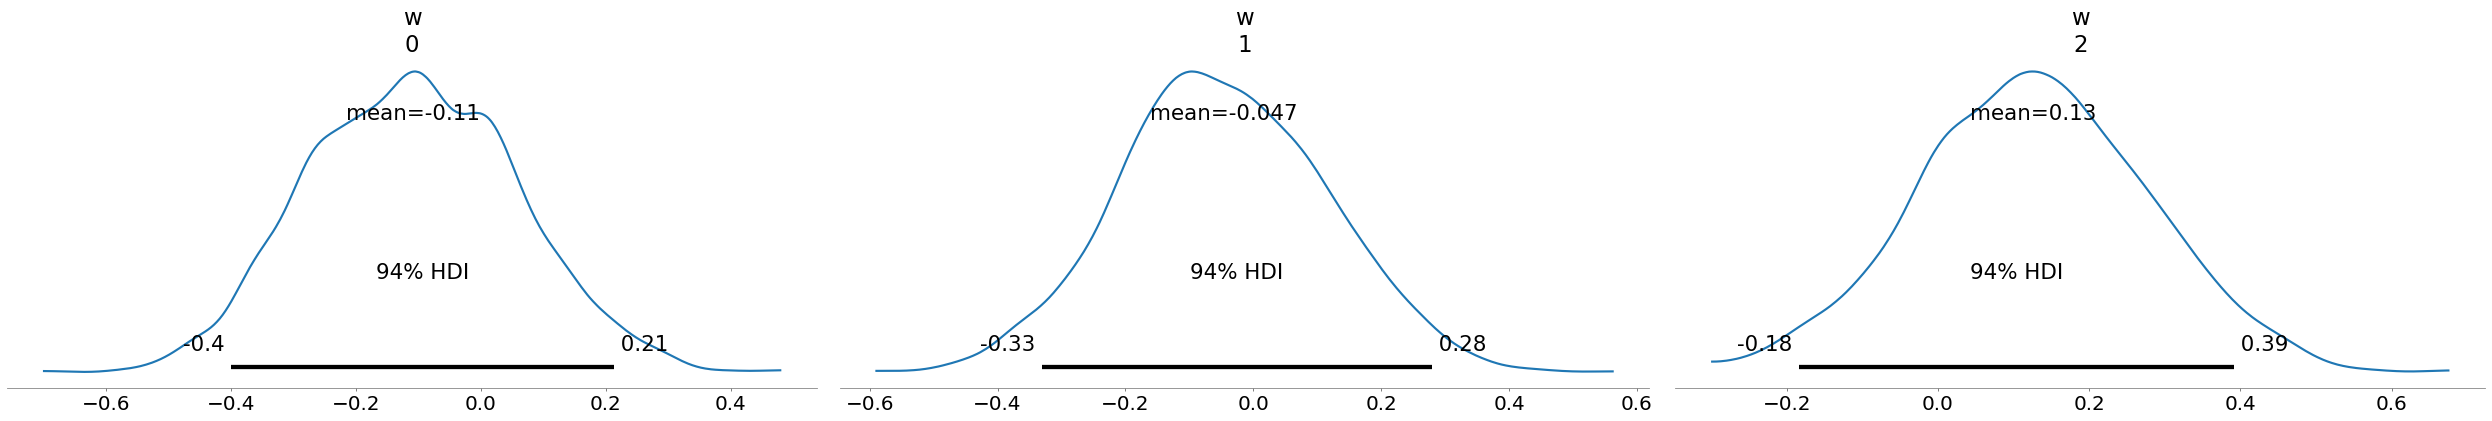

<IPython.core.display.Javascript object>

In [9]:
pm.plot_posterior(trace, var_names=["w"], textsize=20)
plt.show()

### 2. Unpooled Model 

#### Representation  

Since, we'd like to estimate the individual parameters from site $a$ & $b$, the 2 vectors can be augmented as
$
\begin{align*}
\hat{\pmb{w}} =  \begin{bmatrix}  \hat{\pmb{w}}_a  ,   \hat{\pmb{w}}_b\end{bmatrix} 
\end{align*}
$ to give us a $(M \times 2)$ matrix

As seen before the regressors can be augmened into a $(N_a + N_b) \times m$ matrix,
$
\begin{align*}
\pmb{X} = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix}. 
\end{align*}
$

To get to our observations, we first multiple the regressors and the regression coefficients as follows

\begin{align*}
\tilde{\pmb{y}} = {} & \pmb{X} \hat{\pmb{w}}   \\
 = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix} \begin{bmatrix}  \hat{\pmb{w}}_a  ,   \hat{\pmb{w}}_b\end{bmatrix} \\
  = {} & \begin{bmatrix} \hat{\pmb{y}}_{a}, \ \tilde{\pmb{y}}_{ab} \\  \tilde{\pmb{y}}_{ba}, \hat{\pmb{y}}_{b} \end{bmatrix} 
\end{align*}

This gives us an augmented observation matrix of size $(N_a + N_b) \times 2$. Recall that our observations are a _vector_ of the size $(N_a + N_b) \times 1$, i.e.

\begin{align*}
\hat{\pmb{y}} = {} & \begin{bmatrix} \hat{\pmb{y}}_{a} \\ \hat{\pmb{y}}_{b} \end{bmatrix} 
\end{align*}

So, to extract a the observation vector $\hat{\pmb{y}}$ from the augmented matrix $\tilde{\pmb{y}}$, we need to access the 
correct elements: 
\begin{align*}
\hat{\pmb{y}} = {} & \tilde{\pmb{y}}\textsf{.iloc}\left( \begin{bmatrix} 0 & 0 \\ 1 & 0 \\ \vdots & 0 \\ N_a & 0 \\ N_a + 1 & 1 \\ N_a + 2 & 1 \\ \vdots & 1 \\ N_a + N_b & 1 \end{bmatrix}  \right)
\end{align*}



In [10]:
index_cols = tuple(
    np.append(np.zeros(len(X_a), dtype=np.int8), np.ones(len(X_b), dtype=np.int8))
)
index_rows = tuple(np.arange(len(X_a) + len(X_b)))

with pm.Model() as ind_mod:
    # Prior
    # -> Individial priors
    w_ind = pm.Normal(name="w", mu=0, sigma=10, shape=(m, 2))
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)

    # Likelihood
    mu = (X @ w_ind)[index_rows, index_cols]
    obs = pm.Normal(name="obs", observed=y, mu=mu, sigma=sigma)

    # Sample from the posterior
    trace = pm.sample(draws=1500)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 54 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [ ]:
index_cols

In [ ]:
trace.get_values(varname="w").shape

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


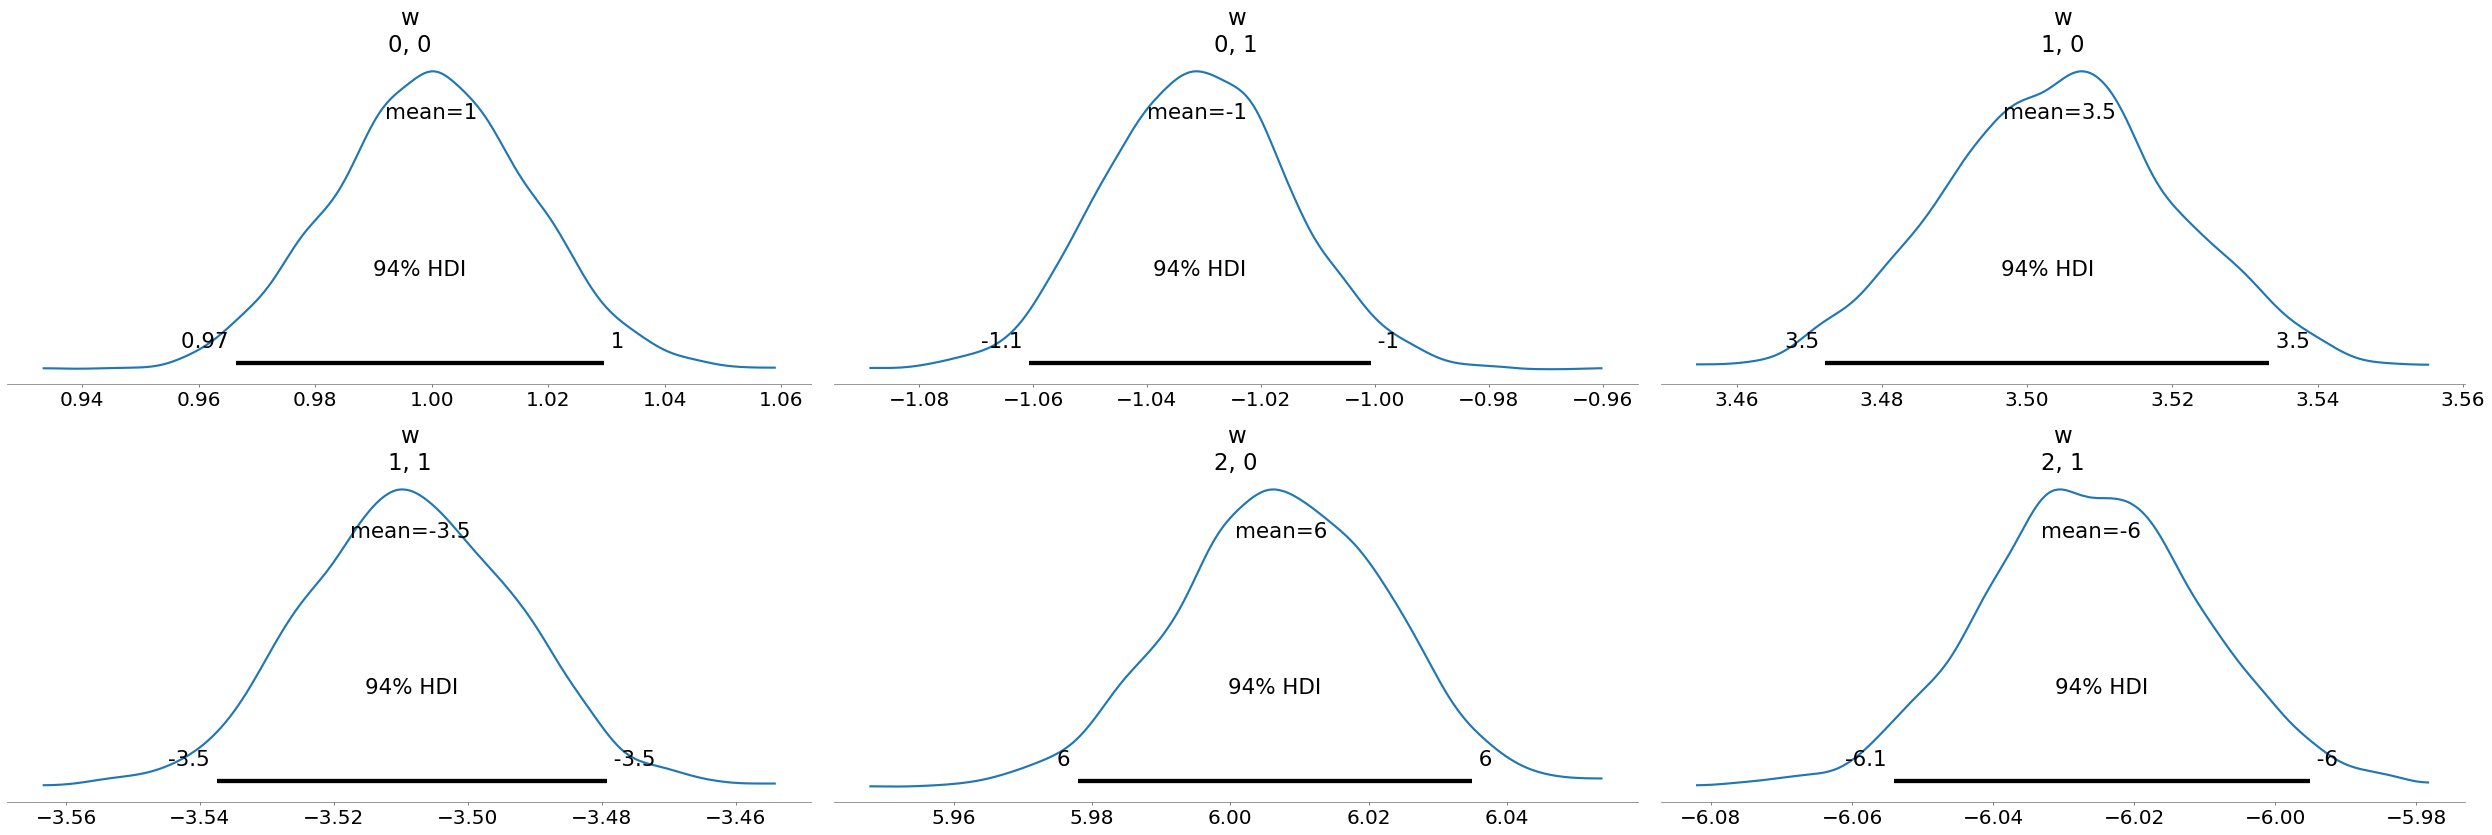

<IPython.core.display.Javascript object>

In [11]:
pm.plot_posterior(trace, var_names=["w"], textsize=20)
plt.show()

In [12]:
with ind_mod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",1.000,0.017,0.966,1.030,0.0,0.0,4235.0,4219.0,4250.0,2444.0,1.0
"w[0,1]",-1.031,0.016,-1.061,-1.001,0.0,0.0,4913.0,4913.0,4926.0,2261.0,1.0
"w[1,0]",3.504,0.016,3.472,3.533,0.0,0.0,5796.0,5796.0,5829.0,2372.0,1.0
"w[1,1]",-3.509,0.016,-3.538,-3.479,0.0,0.0,4428.0,4428.0,4419.0,2315.0,1.0
"w[2,0]",6.007,0.015,5.978,6.035,0.0,0.0,6005.0,6005.0,6076.0,2531.0,1.0
"w[2,1]",-6.026,0.016,-6.054,-5.995,0.0,0.0,4576.0,4575.0,4576.0,2266.0,1.0
sigma,0.500,0.008,0.484,0.514,0.0,0.0,3645.0,3645.0,3649.0,2597.0,1.0


<IPython.core.display.Javascript object>

### 3. Hierarchical Model 

In [13]:
with pm.Model() as hierarchical_mod:
    # Prior

    # -> Global Prior
    mu_w_glob = pm.Normal(name="mu_w", mu=0, sigma=10, shape=(m, 1))
    sigma_w_glob = pm.InverseGamma("sigma_w", mu=1, sigma=10)

    # -> Individial priors
    w_hierarchy = pm.Normal(name="w", mu=mu_w_glob, sigma=sigma_w_glob, shape=(m, 2))
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)

    # Likelihood
    mu = (X @ w_hierarchy)[index_rows, index_cols]
    obs = pm.Normal(name="obs", observed=y, mu=mu, sigma=sigma)

    # Sample from the posterior
    trace = pm.sample(draws=1500)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w, sigma_w, mu_w]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 210 seconds.


<IPython.core.display.Javascript object>

In [14]:
with hierarchical_mod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu_w[0,0]",-0.109,3.398,-6.041,6.629,0.055,0.062,3791.0,1498.0,4134.0,2103.0,1.0
"mu_w[1,0]",-0.036,3.516,-6.436,6.872,0.061,0.067,3349.0,1370.0,3423.0,1993.0,1.0
"mu_w[2,0]",0.156,3.416,-5.982,6.575,0.054,0.061,3969.0,1563.0,4161.0,2270.0,1.0
"w[0,0]",1.000,0.017,0.967,1.030,0.000,0.000,4935.0,4935.0,4931.0,2247.0,1.0
"w[0,1]",-1.031,0.015,-1.061,-1.003,0.000,0.000,3744.0,3744.0,3763.0,2171.0,1.0
"w[1,0]",3.505,0.016,3.476,3.533,0.000,0.000,4696.0,4696.0,4681.0,2134.0,1.0
"w[1,1]",-3.508,0.016,-3.538,-3.480,0.000,0.000,4519.0,4519.0,4501.0,2246.0,1.0
"w[2,0]",6.008,0.016,5.980,6.038,0.000,0.000,5578.0,5575.0,5518.0,2005.0,1.0
"w[2,1]",-6.026,0.016,-6.055,-5.996,0.000,0.000,4930.0,4930.0,4944.0,2025.0,1.0
sigma_w,5.072,1.857,2.318,8.304,0.043,0.031,1834.0,1834.0,1996.0,1775.0,1.0


<IPython.core.display.Javascript object>